In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import bisect
import functools
import io

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(1)

In [4]:
LARGE = 100000

### Load data

In [5]:
# download data
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [6]:
# download the vocabulary file.
terms_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

vocab = None
with io.open(terms_path, 'r', encoding='utf8') as f:
    vocab = list(set(f.read().split()))

vocab.sort()

In [7]:
# load data
def parse_fn(record):
    features = {
        "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
        "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
    }
  
    parsed_features = tf.parse_single_example(record, features)

    terms = parsed_features['terms'].values
    labels = parsed_features['labels']

    return  terms, labels


filenames = tf.placeholder(tf.string, shape=[None])
ds = tf.data.TFRecordDataset(filenames)
ds = ds.map(parse_fn)
ds = ds.padded_batch(LARGE, ds.output_shapes)
ds_iter = ds.make_initializable_iterator()

with tf.Session() as sess:
    sess.run(ds_iter.initializer, feed_dict={filenames: [train_path]})
    x_train, y_train = sess.run(ds_iter.get_next())

    sess.run(ds_iter.initializer, feed_dict={filenames: [test_path]})
    x_test, y_test = sess.run(ds_iter.get_next())

### Process data

Specifically need to replace each word with a vocabulary index; pad with '-1' so not jagged

In [8]:
# process the data
@functools.lru_cache(maxsize=None, typed=False)
def get_word_index(word):
    i = bisect.bisect_left(vocab, word)
    if i != len(vocab) and vocab[i] == word:
        return i

    
def convert_words_to_index(words):
    idx = []
    for word in words:
        if word == b'':
            continue
        i = get_word_index(word.decode('utf-8'))
        if i:
            idx.append(i)
    idx += [-1] * (len(words) - len(idx))
    return idx


x_train = np.array([convert_words_to_index(words) for words in x_train])
x_test = np.array([convert_words_to_index(words) for words in x_test])

### Build graph

In [9]:
VOCAB_SIZE = len(vocab)
EMBED_SIZE = 2

x = tf.sparse_placeholder(tf.int32)
y = tf.placeholder(tf.int32, shape=[None, 1])

embed_matrix = tf.get_variable('embed_matrix', 
                               shape=[VOCAB_SIZE, EMBED_SIZE],
                               initializer=tf.truncated_normal_initializer())

embed = tf.nn.embedding_lookup_sparse(embed_matrix, x, None, name='embedding')

hidden_layer1 = tf.layers.Dense(units=10)
hidden_layer2 = tf.layers.Dense(units=10)
logit_layer = tf.layers.Dense(units=2)

hidden1 = hidden_layer1(embed)
hidden2 = hidden_layer2(hidden1)
logits = logit_layer(hidden2)

pred_class = tf.argmax(logits, 1)
pred_prob = tf.nn.softmax(logits)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

optimizer = tf.train.AdagradOptimizer(learning_rate=0.25)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)

train_op = optimizer.minimize(loss)

### Train model

In [10]:
# construct inputs
def input_fn(x, y, batch_size=1, shuffle=True, num_epochs=None):    
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if shuffle:
        ds = ds.shuffle(buffer_size=LARGE)
    
    ds = ds.repeat(num_epochs).batch(batch_size)
    return ds.make_one_shot_iterator().get_next()


train_iterator = input_fn(x_train, y_train, batch_size=25, shuffle=True, num_epochs=10)

In [11]:
# train
def np_to_sparse_tensor(arr, null_idx=-1):
    idx  = np.where(arr != null_idx)
    return tf.SparseTensorValue(np.vstack(idx).T, arr[idx], arr.shape)


with tf.Session() as sess:
    var_init = tf.global_variables_initializer()
    sess.run(var_init)

    step = 0
    step_stats = []
    while True:
        try:
            xi_train, yi_train = sess.run(train_iterator)
            sess.run(train_op, feed_dict={x: np_to_sparse_tensor(xi_train), y: yi_train})
            
            step += 1
            if (step % 100) == 0:
                y_test_pred = sess.run(pred_class, feed_dict={x: np_to_sparse_tensor(x_test), y: y_test})
                step_stats.append(roc_auc_score(y_test, y_test_pred))
                
        except tf.errors.OutOfRangeError:
            break

    y_test_pred = sess.run(pred_class, feed_dict={x: np_to_sparse_tensor(x_test), y: y_test})
    
    print("Accuracy: ", accuracy_score(y_test, y_test_pred))
    print("AUC: ", roc_auc_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

Accuracy:  0.85288
AUC:  0.85288
             precision    recall  f1-score   support

        0.0       0.85      0.85      0.85     12500
        1.0       0.85      0.85      0.85     12500

avg / total       0.85      0.85      0.85     25000



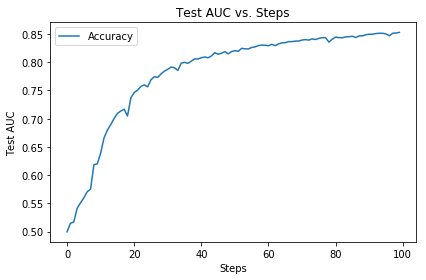

In [12]:
# graph of loss metrics over periods
stats = np.array(step_stats)
plt.ylabel('Test AUC')
plt.xlabel('Steps')
plt.title('Test AUC vs. Steps')
plt.tight_layout()
plt.plot(stats, label='Accuracy')
plt.legend()
plt.show()